# Physics Simulator Coding Exercise
## For PassiveLogic
### Jacob Child
### Jan 15, 2026

**Background:** Almost all equations and the process are taken from [Solar Engineering of Thermal Processes](https://lib.byu.edu/search/byu/record/cram.126.ocn836402985.1). Some concepts and ideas also came from other resources and AI. AI also provided with code implementation, although generally after initial attempts by me.

**Assumptions:** Most assumptions are mentioned next to the relevant variable or equation. Some key assumptions include: steady state conditions for the collector (i.e I'm not updating values with time or temperature in a given hour), no heat loss from pipes, no load on the tank.

**Setup Parameters** 

In [53]:
# Packages needed for everything 
using Pkg
Pkg.activate("PassiveLogic"; shared = true)
using DifferentialEquations, Plots
# Note: These are both big packages, and as I am importing the whole thing for both, compilation may initially take a while.

  Activating project at `C:\Users\child\.julia\environments\PassiveLogic`


In [54]:
# Environmental
Tsurr = 20.0 + 273.15 # K, Surrounding temperature (20C)
SunIrradiance = vcat(range(50, 1000, length = 12), range(1000,50, length = 12)) # W/m^2, solar irradiance over the day. Assuming 1000 W/m^2 around noon and 10 at midnight (zero causes issues). Note: this can be replaced by real hourly data 

# Panel 
TiltAngle = 45.0 # degrees, tilt angle of the solar panel
Ac = 2.0 # m^2, area of the solar collector
PanelAbsorptivity = 0.9 # Absorptivity of the solar panel (this can be taken from a datasheet, but is assumed for now)

# System
mdot = 0.02 # kg/s, mass flow rate of the fluid. Note: I am assuming that the pump would be actively controlled, ie run related to load needs and temperature conditions in the tank and collector. For now I am assuming constant. 
Cp = 4180 # J/kg K, specific heat capacity of water at about 20C. This could be made a function of temperature for more accuracy without much difficulty. 
rho = 1000 # kg/m^3, assumed density of water 

# Note: I am assuming no heat losses from the pipes (ie adiabatic pipes). This is just to simplify, and wouldn't be too difficult to add. 

# Tank 
TankVolume = 10 # m^3, This means about 0.72% is replaced per hour at 0.02 kg/s flow rate.
UA_Tank = 3.0 # W/K, overall heat loss coefficient of the tank. This is an assumed value for now. It would be taken from the datasheet, or wall material and thickness 

# Initial Values 
Tinit = 20.0 + 273.15 # K, initial temperature of the tank water
N = 4 # discritization for the tank, pg 382 of the book says this is a conservative balance of mixing and stratification (more efficient)
TsTank = fill(Tinit, N) # K, temp of discretized tank elements
tspan = (0.0, 3600.0) #seconds in an hour, needed to solve the tank ODEs every hour 

# Calculated/derived values from the above 
S = SunIrradiance .* PanelAbsorptivity # W/m^2, solar radiation absorbed by the panel
m_node = (rho * TankVolume) / N # kg, mass of each tank node
UA = UA_Tank/N # W/K, UA per tank node or section 

0.75

**Solar Collector Functions**

In [55]:
### Solar Panel Functions ###
"""
Q_Solar(Sf, Tif; Taf = Tsurr, Acf = Ac)
Sf: Absorbed solar radiation 
Tif: Fluid inlet temperature
Taf: Ambient temperature
Acf: Area of the solar collector
Note: Follows processes shown in Chp 6 of the book, mainly sections 6.4 and 6.9
"""
function Q_Solar(Sf, Tif; Taf = Tsurr, Acf = Ac)
    Tpm = Tif + 10 # Initial guess for mean plate temperature
    Ulf = UL_Solar(Tpm; Taf = Tsurr)# Overall heat loss coefficient
    Frf = FR_Solar(Ulf) # Heat removal factor
    Qu = Acf * (Sf - Ulf * (Tpm - Taf)) # Useful gain of the collector, eqn 6.9.3
    New_Tpm = Tif + (Qu / Acf) / (Frf * Ulf) * (1 - Frf) # New mean plate temperature eqn 6.9.4
    #Iterate 
    k = 0 
    while k < 100
        Tpm = New_Tpm
        Ulf = UL_Solar(Tpm; Taf = Tsurr) # eqn 6.4.9
        Frf = FR_Solar(Ulf)
        Qu = Acf * (Sf - Ulf * (Tpm - Taf))
        Old_Tpm = New_Tpm
        New_Tpm = Tif + (Qu / Acf) / (Frf * Ulf) * (1 - Frf)
        if abs((New_Tpm - Old_Tpm)/Old_Tpm) < 0.01
            break
        end
        k += 1
        if k == 100
            println("Warning: Max iterations reached in Q_Solar calculation")
        end
    end
    # Final calculations 
    Ulf = UL_Solar(New_Tpm; Taf = Tsurr)
    Frf = FR_Solar(Ulf)
    # Total Q to the fluid
    Qf = Acf * Frf * (Sf - Ulf*(Tif - Taf))   

    return Qf

end

"""
FR_Solar(Ulf; Acf = Ac, mdotf = mdot, cpf = Cp)
Ulf: Overall heat loss coefficient
Acf: Area of the solar collector
mdotf: Mass flow rate of the fluid
cpf: Specific heat capacity of the fluid
""" 
function FR_Solar(Ulf; Acf = Ac, mdotf = mdot, cpf = Cp)
    # Fprime = Uof / Ulf # eqn 6.5.19 in the book, ranges from 0.75 to 1.0, to simplify, I am going to arbitrarily set it to 0.875. This avoids calculating Uof, which would also require calculating h for the fluid which is doable, but involved.
    Fprime = 0.875 # see above for explanation, and Fig 6.5.4 in the book, this is called the collector efficiency factor
    
    cap_rate = mdotf * cpf / (Acf * Ulf * Fprime) # Dimensionless collector capacitance rate, sec 6.7
    
    # Heat removal factor (Eq. 6.7.4)
    FRf = cap_rate * Fprime * (1 - exp(-1 / cap_rate)) # from eqn 6.7.4
    return FRf
end

"""
UL_Solar(Tpm; Β=TiltAngle, Nf = 2, Taf = Tsurr)
Tpm: Mean plate temperature
Β: Tilt angle of the solar panel
Nf: Number of glass covers
Taf: Ambient temperature
"""
function UL_Solar(Tpm; Β=TiltAngle, Nf = 2, Taf = Tsurr)
    
    # Solve for Utop first. All below is from eqn 6.4.9
    hw = 10 # W/m^2 K, assuming minimal wind
    ϵg = 0.93 # emissivity of glass, https://www.engineeringtoolbox.com/emissivity-coefficients-d_447.html
    ϵp = 0.95 # emissivity of plate (assumed), this would be from the collector datasheet
    f = (1+0.089*hw - 0.1166*hw*ϵp)*(1+ 0.07866*Nf) 
    if Β > 70
        Β = 70
    end
    C = 520 * (1 - 0.000051*Β^2)
    ef = 0.43 * (1 - 100 / Tpm) # Tpm is the mean plate temp 
    term1 = (Nf / (C/Tpm * ((Tpm - Taf)/(Nf+f))^ef) + 1/hw)^-1
    σ = 5.67e-8 # Stefan-Boltzmann constant
    term2 = σ*(Tpm + Taf)*(Tpm^2 + Taf^2) 
    term3 = 1 / (ϵp + 0.00591*Nf*hw)
    term4 = (2*Nf + f - 1 + 0.133 * ϵp) / ϵg
    Utop = term1 + term2 / (term3 + term4 - Nf)
    Ubot = 0.9 #arbitrary, from book example. It should be calculated as k/L for back wall insulation material, taken from collector datasheet.

    return Utop + Ubot
end

UL_Solar

**Tank Functions**

In [56]:
### Tank Functions ### 
"""
function Fc(i, Tfi, Ts) # eqn 8.4.1 in the book
i: Index of the current tank node
Tfi: Inlet fluid temperature
Ts: Array of tank temperatures
"""
function Fc(i, Tfi, Ts)
    N = length(Ts)

    if i == 1 && Tfi > Ts[1]
        return 1.0
    elseif i >= 2 && Ts[i-1] >= Tfi > Ts[i]
        return 1.0
    elseif i == 0 || i == N + 1
        return 0.0
    else 
        return 0.0
    end
end

# For now I am going to assume no load on the tank, so I will ignore the load terms 

"""
function mixed_flow_mdots(Fcs, mdot) #eqn 8.4.3
Fcs: Array of flow control factors
mdot: Mass flow rate of the fluid
"""
function mixed_flow_mdots(Fcs, mdot) #eqn 8.4.3
    N = length(Fcs)
    mdot_m = zeros(N+1)
    for i in 2:N # indexing seems different, but [1] = 0 and [N+1] = 0 as they should 
        mdot_m[i] = mdot * sum(Fcs[1:i-1])
    end
    return mdot_m
end 


"""
ode form:
function f!(dT, T, p, t)
    where dT is the derivative of T with respect to time and p are parameters
    the function updates dT in place ie dT[i] = ...
end
Note: AI significantly helped with this function and putting it in the proper format to update all nodes of the tank at once and in place etc
"""
function TankODE!(dT, Ts, p, t)
    mdot, Tif, UA, Cp, m, Ta = p 
    N = length(Ts)

    Fcs = [Fc(i, Tif, Ts) for i in 1:N] # Flow control function 
    

    mdot_ms = mixed_flow_mdots(Fcs, mdot) # Mixed flow mdots

    for i in 1:N 
        Losses = (UA / Cp) * (Ta - Ts[i])
        InletTerm = Fcs[i] * mdot * (Tif - Ts[i])
        #mixing 
        MixingTerm = 0.0
        if mdot_ms[i] > 0 && i > 1
            MixingTerm = mdot_ms[i] * (Ts[i-1] - Ts[i])
        elseif mdot_ms[i+1] < 0 && i < N
            MixingTerm = mdot_ms[i+1] * (Ts[i] - Ts[i+1])
        end
        dT[i] = (Losses + InletTerm + MixingTerm) / m # this assumes every section is the same mass
    end
end


TankODE!

**Calculations**

In [57]:
# Initialize 
Tin_collector = Tinit 
TsTank_new = TsTank
TotalTankEnergy = zeros(length(S)) # To track total energy in the tank over time

for (i, Sf) in enumerate(S) 
    # Collector calculations
    Q = Q_Solar(Sf, Tin_collector; Taf = Tsurr, Acf = Ac) # W
    Tout_collector = Tin_collector + Q / (mdot * Cp) # K

    # Tank ODEs 
    p = (mdot = mdot, Tif = Tout_collector, UA = UA, Cp = Cp, m = m_node, Ta = Tsurr)
    prob = ODEProblem(TankODE!, TsTank_new, tspan, p)
    sol = solve(prob, Rodas5(), reltol=1e-6, abstol=1e-8) #AI recommended solver and tolerances, they seem to work. 
    TsTank_new = sol.u[end] # Update tank temperatures for the next hour
    Tin_collector = TsTank_new[end] # Assume outlet temp (bottom of the tank) is inlet temp of collector for next hour
    TotalTankEnergy[i] = sum(TsTank_new) * m_node * Cp # J, total energy in the tank at this time step
end


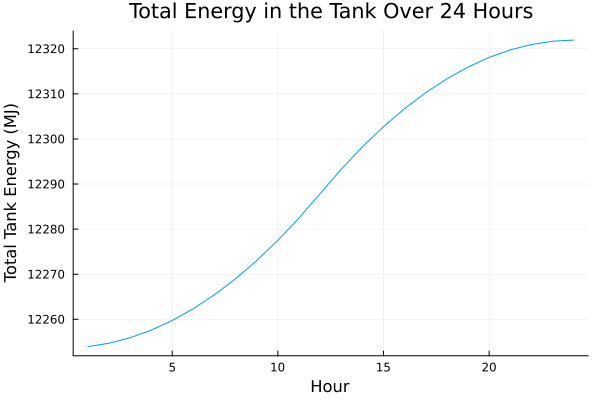

In [58]:
TotalTankEnergy = TotalTankEnergy./ 1000000 #MJ
hours = collect(1:length(S)) # hours for plotting
plot(hours, TotalTankEnergy, xlabel = "Hour", ylabel = "Total Tank Energy (MJ)", title = "Total Energy in the Tank Over 24 Hours", legend = false)

**Future Work:** I think the most important future work is to put a load on the tank to make it more realistic. That shouldn't be too difficult. Then I should verify all of the assumed physical parameters (tank loss coefficient, collector absorption efficiency, etc). Also get accurate solar data. Combined, these will give the most realistic results. The last thing I would update is the simplifications I made, actually updating values with time and temperature, and calculating h and Nu and Pr on the fly etc. Bugs in the code I need to work out include why it doesn't work if S = 0 or less than about 40-50ish I think.